# A2 - Complex Networks
### Authors: Ignacio Miguel Rodríguez and Daniel Arias Cámara

The objective of this activity is to understand how community detection algorithms work and some of the recurrent nuances appearing when using these tools to characterize the mesoscale of complex networks. The activity is divided into two different tasks.

## Part 1: Characterization of the community structure of networks with block structure

In this part of the activity, you will use community detection algorithms to analyze the community structure of networks generated according to the stochastic block model (SBM). The parameters characterizing the networks are:

- **_N=300_**: number of nodes. For all the networks.
- **_nblocks=5_**: number of different blocks (types) of nodes. For all the networks.
- **_prs=0.02_**: Probability that a node (belonging to a given block) establishes a link with another node from a different block. For all networks here studied.
- **_prr=0.04_**: Probability that a single node (belonging to a given block) establishes a link with another node from the same block. This indicator varies across networks, being its value indicated in each filename. For example, for the synthetic network in file ‘synthetic_network_N_300_blocks_5_prr_0.04_prs_0.02.net’.

You should use at least three algorithms to find the community structure of the different networks provided in the dataset, i.e., as prr varies from prr=0 (no connections inside each block) to prr=1 (all-to-all interactions inside blocks). Out of these three algorithms, one should be **Infomap** whereas the other two should be **modularity maximization algorithms**, e.g., Girvan-Newman, Agglomerative Greedy algorithm, Louvain, Leiden, etc. Note that, for all the synthetic networks, the ‘true’ group structure is known. Namely, the first 60 nodes (labeled as 1, 2, 3, …,60) are contained in group 1, the next 60 (labeled 60, 62, ..., 120) in group 2, and so on. 

The report must include:

1. Evolution of the number of communities and the modularity of the partitions found by each algorithm as a function of prr. You should also compare the partition found by each algorithm with the ‘true’ partition using at least the following standard measures: Jaccard Index, Normalized Mutual Information (arithmetic normalization), and Normalized Variation of Information. It is not necessary to implement the calculation of these indices, you may use any program. Beware that you may find implementations of the Jaccard Index that are not related to community detection, thus the results would be incorrect.

2. A color-coded visualization of the community structure of the network for prr=0.02, prr=0.16, and prr=1.00. To facilitate the comparison of partitions, you should set the position of the nodes in the network by applying any of the algorithms available for representation (e.g., Kamada-Kawai, ForceAtlas, Fruchterman-Reingold, etc.) to the network with prr=1.00. The positions obtained for each node should be kept when representing the other two networks. In each network, the node's color should identify the community assigned by each community detection algorithm. 

3. A brief discussion on the limitations of the use of modularity to classify whether a network has community structure or not. For instance, from your results, can we state that a network with Q=0.4 has community structure? Why?

4. A brief discussion of the differences observed across algorithms. Are the communities detected by both of them equal? Are the modularity values obtained equal? Why?

Processing network: A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.00_prs_0.02.net
prr=0.00 | Communities: 12 | Modularity: 0.4448 | Jaccard: 0.0252 | NMI: 0.0215 | NVI: 0.7178
Processing network: A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.02_prs_0.02.net
prr=0.02 | Communities: 13 | Modularity: 0.3767 | Jaccard: 0.0213 | NMI: 0.0378 | NVI: 1.0563
Processing network: A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.04_prs_0.02.net
prr=0.04 | Communities: 12 | Modularity: 0.3369 | Jaccard: 0.0294 | NMI: 0.0573 | NVI: 0.8066
Processing network: A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.06_prs_0.02.net
prr=0.06 | Communities: 12 | Modularity: 0.3052 | Jaccard: 0.0161 | NMI: 0.0950 | NVI: 0.8137
Processing network: A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.08_prs_0.02.net
prr=0.08 | Communities: 8 | Modularity: 0.3054 | Jaccard: 0.0872 | NMI: 0.1722 | NVI: 0.3848
Processing network: A3_synthetic_networks/synt

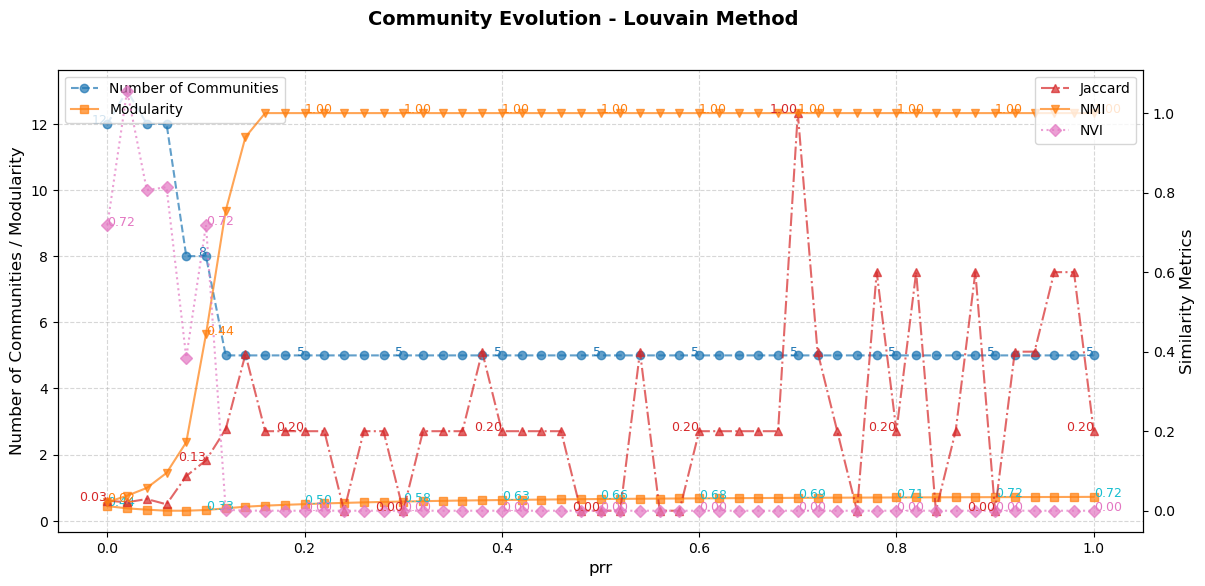

In [11]:
import networkx as nx
import community as community_louvain  # For Louvain method
from networkx.algorithms.community import girvan_newman
from infomap import Infomap  # Requires 'infomap' package
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, normalized_mutual_info_score
from scipy.stats import entropy

def analyze_network_evolution(method="louvain"):
    results = []

    for i in range(0, 101, 2):
        prr = i / 100
        file_path = f"A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_{prr:.2f}_prs_0.02.net"
        G = _load_network(file_path)

        print(f"Processing network: {file_path}")

        # Get the ground-truth partition
        true_partition = _get_true_partition(G)

        # Run the selected community detection method
        if method == "louvain":
            partition, num_communities = _louvain(G)
        elif method == "girvan_newman":
            partition, num_communities = _girvan_newman(G)
        elif method == "infomap":
            partition, num_communities = _infomap(G)
        else:
            raise ValueError("Method must be 'louvain', 'girvan_newman', or 'infomap'.")

        # Compute modularity
        modularity = community_louvain.modularity(partition, G)

        # Compute similarity metrics
        jaccard, nmi, nvi = _compare_partitions(true_partition, partition, G)

        # Store results
        results.append({
            "prr": prr,
            "num_communities": num_communities,
            "modularity": modularity,
            "jaccard": jaccard,
            "nmi": nmi,
            "nvi": nvi,
        })

        print(f"prr={prr:.2f} | Communities: {num_communities} | Modularity: {modularity:.4f} | "
              f"Jaccard: {jaccard:.4f} | NMI: {nmi:.4f} | NVI: {nvi:.4f}")

    return results


def _load_network(file_path=""):
    G = nx.read_pajek(file_path)

    if nx.is_directed(G):
        G = G.to_undirected()

    if G.is_multigraph():
        G = nx.Graph(G)

    return nx.relabel_nodes(G, {node: int(node) for node in G.nodes()})


def _get_true_partition(G):
    """Returns the ground-truth partition (5 blocks of 60 nodes)."""
    true_partition = {}
    for node in G.nodes():
        true_partition[node] = (node - 1) // 60  # Each 60 nodes belong to the same block
    return true_partition


def _louvain(G):
    partition = community_louvain.best_partition(G)
    num_communities = len(set(partition.values()))
    return partition, num_communities


def _girvan_newman(G):
    communities = list(girvan_newman(G))
    if communities:
        first_partition = tuple(sorted(c) for c in next(iter(communities)))
        num_communities = len(first_partition)
        partition = {node: i for i, comm in enumerate(first_partition) for node in comm}
        return partition, num_communities
    return {}, 0


def _infomap(G):
    im = Infomap()
    for node in G.nodes():
        im.add_node(node)
    for u, v in G.edges():
        im.add_link(u, v)
    im.run()
    partition = im.get_modules()
    num_communities = len(set(partition.values()))
    return partition, num_communities


def _compare_partitions(true_partition, detected_partition, G):
    """Computes Jaccard Index, NMI, and Normalized Variation of Information (NVI)."""
    true_labels = [true_partition[node] for node in sorted(G.nodes())]
    detected_labels = [detected_partition.get(node, -1) for node in sorted(G.nodes())]  # -1 for missing nodes

    jaccard = jaccard_score(true_labels, detected_labels, average="macro")
    nmi = normalized_mutual_info_score(true_labels, detected_labels)

    # Compute normalized variation of information (NVI)
    true_clusters = set(true_partition.values())
    detected_clusters = set(detected_partition.values())

    # Create aligned probability distributions
    all_clusters = true_clusters.union(detected_clusters)  # Ensure same set of labels
    p1 = [list(true_partition.values()).count(c) / len(true_partition) for c in all_clusters]
    p2 = [list(detected_partition.values()).count(c) / len(detected_partition) for c in all_clusters]

    nvi = entropy(p1, p2)  # Normalized VI

    return jaccard, nmi, nvi




def plot_results(results, method):
    """Plots the evolution of metrics over prr with improved visualization and numerical labels."""
    prr_values = [r["prr"] for r in results]
    num_communities = [r["num_communities"] for r in results]
    modularity = [r["modularity"] for r in results]
    jaccard = [r["jaccard"] for r in results]
    nmi = [r["nmi"] for r in results]
    nvi = [r["nvi"] for r in results]

    fig, ax1 = plt.subplots(figsize=(14, 6))  # Even wider plot

    # Primary y-axis (Number of Communities + Modularity)
    ax1.set_xlabel("prr", fontsize=12)
    ax1.set_ylabel("Number of Communities / Modularity", fontsize=12)
    line1, = ax1.plot(prr_values, num_communities, label="Number of Communities", linestyle="--", marker="o", alpha=0.7)
    line2, = ax1.plot(prr_values, modularity, label="Modularity", linestyle="-", marker="s", alpha=0.7)
    ax1.tick_params(axis="y")
    ax1.grid(True, linestyle="--", alpha=0.5)  # Add grid for better readability

    # Add numerical values along the lines (only for some points)
    for i in range(0, len(prr_values), 5):  # Show every 5th label to avoid clutter
        ax1.text(prr_values[i], num_communities[i], f"{num_communities[i]}", fontsize=9, ha="right", color="tab:blue")
        ax1.text(prr_values[i], modularity[i], f"{modularity[i]:.2f}", fontsize=9, ha="left", color="tab:cyan")

    # Secondary y-axis (Similarity Metrics)
    ax2 = ax1.twinx()
    ax2.set_ylabel("Similarity Metrics", fontsize=12)
    line3, = ax2.plot(prr_values, jaccard, label="Jaccard", color="tab:red", linestyle="-.", marker="^", alpha=0.7)
    line4, = ax2.plot(prr_values, nmi, label="NMI", color="tab:orange", linestyle="-", marker="v", alpha=0.7)
    line5, = ax2.plot(prr_values, nvi, label="NVI", color="tab:pink", linestyle=":", marker="D", alpha=0.7)
    ax2.tick_params(axis="y")

    # Add numerical values along the lines (only for some points)
    for i in range(0, len(prr_values), 5):
        ax2.text(prr_values[i], jaccard[i], f"{jaccard[i]:.2f}", fontsize=9, ha="right", color="tab:red")
        ax2.text(prr_values[i], nmi[i], f"{nmi[i]:.2f}", fontsize=9, ha="left", color="tab:orange")
        ax2.text(prr_values[i], nvi[i], f"{nvi[i]:.2f}", fontsize=9, ha="left", color="tab:pink")

    # Titles and Legends
    fig.suptitle(f"Community Evolution - {method.capitalize()} Method", fontsize=14, fontweight="bold")

    # Improved legend positioning
    ax1.legend(handles=[line1, line2], loc="upper left", fontsize=10, frameon=True)
    ax2.legend(handles=[line3, line4, line5], loc="upper right", fontsize=10, frameon=True)

    plt.show()


# Example Usage:
method = "louvain"  # Change to "girvan_newman" or "infomap" as needed
results = analyze_network_evolution(method)
plot_results(results, method)


## Part 2: Characterization of the community structure of real networks

In this part of the activity, you should use algorithms relying on modularity maximization to analyze the community structure of a real network capturing face-to-face interactions in a primary school in France. In this network, nodes represent either students or teachers and weights are proportional to the time they were together during the two days in which interactions were measured. More information on the network can be found here: 

http://www.sociopatterns.org/publications/high-resolution-measurements-of-face-to-face-contact-patterns-in-a-primary-school/

You should analyze both the unweighted (‘primaryschool_u.net’) and the weighted (‘primaryschool_w.net’) versions of this network. In addition, node metadata is available (metadata_primary_school.txt), indicating the school group each individual belongs to.

The report must include:

1. A comparison between the community structure found in both the unweighted and the weighted networks. Use a color-coded representation, similar to the one explained in the previous activity. The position of the nodes should be set by applying the chosen positioning algorithm to the weighted network. **Warning**: If you choose the Kamada-Kawai layout algorithm to visualize the network, the weights introduced in the algorithm should be the inverse (1/wij) of the actual weights (wij) of the network. Nonetheless, you should keep using the actual weights for community detection.

2. The composition of the detected communities in terms of the school groups to which their individuals belong. You should provide a visual representation (e.g. a stacked bar plot, a pie chart) to show how many individuals of each school group are in each community.

3. A brief discussion on the differences among the communities detected in the weighted and unweighted network. Why weights are relevant?